# scikit-FIBERS: Demonstration Notebook
This notebook is set up as a demonstration for running scikit-FIBERS.

***
## Imports:

In [1]:
import os
import pickle
import pandas as pd
from sklearn.metrics import classification_report
# If pip installed
#from skfibers.fibers import FIBERS
#from skfibers.experiments.survival_sim_simple import survival_data_simulation
# If locally run
from src.skfibers.fibers import FIBERS
from src.skfibers.experiments.survival_sim_simple import survival_data_simulation

current_working_directory = os.getcwd()
print(current_working_directory)

c:\Users\UrbanowiczR\Documents\GitHub\scikit-FIBERS


***
## Set Up Local Run Parameters


In [2]:
local_save = False
folder_path = './output'
if not os.path.exists(folder_path):
        os.makedirs(folder_path)
if local_save:
    output_folder = './output'
else:
    output_folder = folder_path

#Turns off comprehensive cox analysis over all bins and generation of respective figures
quick_run = True

***
## Generate Simulated Survial Data

In [3]:
data_name = 'example_dataset'
data = survival_data_simulation(instances=500, total_features=100, predictive_features=5, low_risk_proportion=0.5, threshold = 2, feature_frequency_range=(0.1, 0.4), 
                         noise_frequency=0.0, class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2), censoring_frequency=0.2, 
                         negative_control=False, random_seed=42)
data.to_csv(output_folder+'/'+data_name+'.csv', index=False)
data = pd.read_csv(output_folder+'/'+data_name+'.csv')
true_risk_group = data[['TrueRiskGroup']]
data = data.drop('TrueRiskGroup', axis=1)

value_counts = true_risk_group['TrueRiskGroup'].value_counts()
print(value_counts)

Unique binary numbers: 32
Unique HR Combos: 16
Unique LR Combos: 16
Target predictive feature(s) 'one's counts: [145, 53, 91, 83, 160]
Random Number Check: 53852
TrueRiskGroup
0    250
1    250
Name: count, dtype: int64


***
## Run FIBERS (Training)

In [4]:
fibers = FIBERS(outcome_label="Duration", outcome_type="survival", iterations=50, pop_size=50, tournament_prop=0.2, crossover_prob=0.5, min_mutation_prob=0.1, max_mutation_prob=0.5, merge_prob=0.1, 
                new_gen=1.0, elitism=0.1, diversity_pressure=0, min_bin_size=1, max_bin_size=None, max_bin_init_size=10, fitness_metric="log_rank", log_rank_weighting=None, censor_label="Censoring", 
                group_strata_min=0.2, penalty=0.5, group_thresh=None, min_thresh=0, max_thresh=5, int_thresh=True, thresh_evolve_prob=0.5, manual_bin_init=None, covariates=None, pop_clean = 'group_strata',  
                report=[0,10,20,30,40], random_seed=42,verbose=False)
fibers = fibers.fit(data)

Dropped 0 invariant feature columns.
                                         feature_list  group_threshold  \
0                  [P_1, P_3, R_24, R_25, R_66, R_71]                2   
1                 [P_1, R_10, R_16, R_33, R_51, R_54]                1   
2   [P_4, P_5, R_23, R_25, R_50, R_60, R_7, R_71, ...                3   
3                             [R_31, R_44, R_54, R_8]                1   
4   [P_3, R_10, R_26, R_3, R_35, R_37, R_42, R_58,...                1   
5    [R_13, R_14, R_27, R_29, R_46, R_54, R_78, R_91]                1   
6                  [P_5, R_25, R_3, R_36, R_94, R_95]                5   
7            [P_1, R_17, R_29, R_3, R_44, R_45, R_54]                1   
8                  [R_2, R_3, R_57, R_60, R_63, R_70]                4   
9                                         [P_4, R_90]                0   
10  [R_12, R_23, R_26, R_31, R_58, R_65, R_69, R_8...                1   
11  [R_21, R_24, R_49, R_53, R_65, R_71, R_79, R_8...                5   
1

 20%|██        | 10/50 [00:09<00:36,  1.11it/s]

ITERATION: 10
                                feature_list  group_threshold   fitness  \
0                 [P_1, P_3, P_4, P_5, R_27]                2  1.000000   
1                            [P_1, P_3, P_5]                1  0.951229   
2                      [P_1, P_3, P_5, R_95]                1  0.904837   
3                      [P_1, P_3, P_5, R_71]                2  0.860708   
4                      [P_1, P_3, P_5, R_90]                1  0.818731   
5                                 [P_1, P_5]                1  0.778801   
6                      [P_1, P_3, P_5, R_90]                2  0.740818   
7                            [P_3, P_4, P_5]                1  0.704688   
8                                 [P_3, P_5]                1  0.670320   
9                      [P_1, P_3, P_5, R_89]                1  0.637628   
10                           [P_1, P_3, P_5]                2  0.606531   
11                                [P_1, P_3]                1  0.576950   
12         

 40%|████      | 20/50 [00:19<00:30,  1.00s/it]

ITERATION: 20
                                       feature_list  group_threshold  \
0                         [P_1, P_2, P_3, P_4, P_5]                2   
1                   [P_1, P_2, P_3, P_4, P_5, R_10]                2   
2                              [P_1, P_3, P_4, P_5]                2   
3                   [P_1, P_2, P_3, P_4, P_5, R_27]                2   
4                   [P_1, P_2, P_3, P_4, P_5, R_48]                2   
5                   [P_1, P_2, P_3, P_4, P_5, R_13]                2   
6             [P_1, P_2, P_3, P_4, P_5, R_10, R_48]                2   
7                   [P_1, P_2, P_3, P_4, P_5, R_40]                2   
8             [P_1, P_2, P_3, P_4, P_5, R_13, R_27]                2   
9             [P_1, P_2, P_3, P_4, P_5, R_27, R_68]                2   
10                       [P_1, P_3, P_4, P_5, R_63]                2   
11                       [P_1, P_3, P_4, P_5, R_68]                2   
12                  [P_1, P_2, P_3, P_4, P_5, R_92

 60%|██████    | 30/50 [00:29<00:20,  1.02s/it]

ITERATION: 30
                                         feature_list  group_threshold  \
0                           [P_1, P_2, P_3, P_4, P_5]                2   
1                     [P_1, P_2, P_3, P_4, P_5, R_10]                2   
2                                [P_1, P_3, P_4, P_5]                2   
3                     [P_1, P_2, P_3, P_4, P_5, R_27]                2   
4                     [P_1, P_2, P_3, P_4, P_5, R_86]                2   
5                          [P_1, P_3, P_4, P_5, R_86]                2   
6                     [P_1, P_2, P_3, P_4, P_5, R_48]                2   
7                          [P_1, P_3, P_4, P_5, R_10]                2   
8                     [P_1, P_2, P_3, P_4, P_5, R_80]                2   
9               [P_1, P_2, P_3, P_4, P_5, R_10, R_24]                2   
10                         [P_1, P_3, P_4, P_5, R_27]                2   
11                    [P_1, P_2, P_3, P_4, P_5, R_40]                2   
12                    [P

 80%|████████  | 40/50 [00:39<00:10,  1.09s/it]

ITERATION: 40
                                   feature_list  group_threshold   fitness  \
0                     [P_1, P_2, P_3, P_4, P_5]                2  1.000000   
1               [P_1, P_2, P_3, P_4, P_5, R_10]                2  0.951229   
2                [P_1, P_2, P_3, P_4, P_5, R_2]                2  0.904837   
3                          [P_1, P_3, P_4, P_5]                2  0.860708   
4          [P_1, P_2, P_3, P_4, P_5, R_10, R_2]                2  0.818731   
5               [P_1, P_2, P_3, P_4, P_5, R_27]                2  0.778801   
6         [P_1, P_2, P_3, P_4, P_5, R_10, R_68]                2  0.740818   
7               [P_1, P_2, P_3, P_4, P_5, R_95]                2  0.704688   
8               [P_1, P_2, P_3, P_4, P_5, R_47]                2  0.670320   
9                    [P_1, P_3, P_4, P_5, R_86]                2  0.637628   
10        [P_1, P_2, P_3, P_4, P_5, R_10, R_42]                2  0.606531   
11              [P_1, P_2, P_3, P_4, P_5, R_46]   

100%|██████████| 50/50 [00:55<00:00,  1.11s/it]

                                  feature_list  group_threshold   fitness  \
0                    [P_1, P_2, P_3, P_4, P_5]                2  1.000000   
1              [P_1, P_2, P_3, P_4, P_5, R_10]                2  0.951229   
2               [P_1, P_2, P_3, P_4, P_5, R_2]                2  0.904837   
3                         [P_1, P_3, P_4, P_5]                2  0.860708   
4              [P_1, P_2, P_3, P_4, P_5, R_68]                2  0.818731   
5         [P_1, P_2, P_3, P_4, P_5, R_10, R_2]                2  0.778801   
6              [P_1, P_2, P_3, P_4, P_5, R_20]                2  0.740818   
7              [P_1, P_2, P_3, P_4, P_5, R_46]                2  0.704688   
8              [P_1, P_2, P_3, P_4, P_5, R_79]                2  0.670320   
9                   [P_1, P_3, P_4, P_5, R_10]                2  0.637628   
10             [P_1, P_2, P_3, P_4, P_5, R_52]                2  0.606531   
11       [P_1, P_2, P_3, P_4, P_5, R_10, R_95]                2  0.576950   

### Report Run Time

In [5]:
# Report run time
print(fibers.elapsed_time)

60.68199324607849


***
## Top (or Target) Bin Examination
### Specify Bin to Examine

In [6]:
bin_index = 0 # lowest index is the bin with the highest fitness (only reports the bin ranked at the top, despite possible fitness ties for top)

### Get Bin Details

In [7]:
fibers.get_bin_report(bin_index)

,0
Features in Bin:,"[P_1, P_2, P_3, P_4, P_5]"
Threshold:,2
Fitness,1.0
Pre-Fitness:,365.620641
Log-Rank Score:,365.620641
Log-Rank p-value:,0.0
Bin Size:,5
Group Ratio:,0.5
Count At/Below Threshold:,250
Count Above Threshold:,250


### Plot: Kaplan Meier Survival Curves For Each Group Defined by the Target Bin

Dropped 0 invariant feature columns.


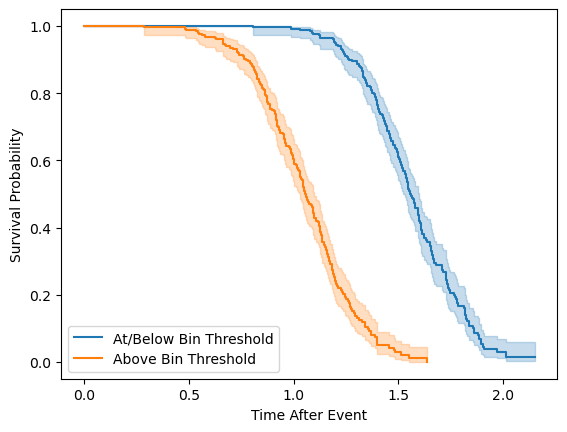

In [8]:
fibers.get_kaplan_meir(data,bin_index,save=True,output_folder=output_folder,data_name=data_name)

### Check and View Any Top Bin Ties

In [9]:
fibers.report_ties()


Only one top performing bin found


***
## Bin Population Examination
### Plot: Basic Bin Population Heatmap


9


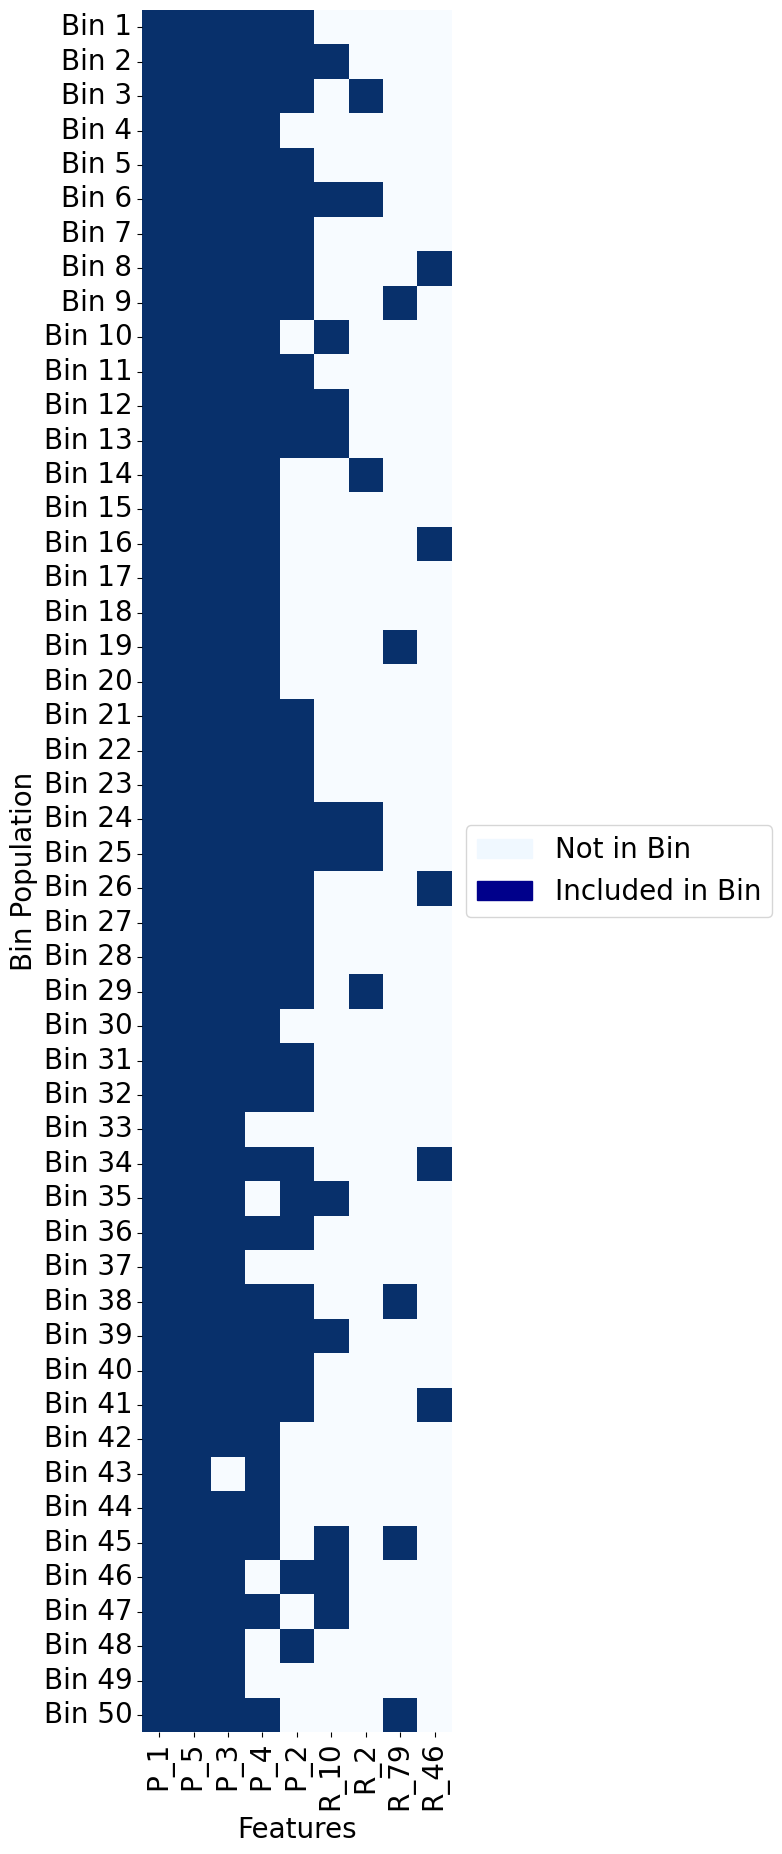

In [10]:
graph_df = fibers.get_bin_population_heatmap_plot(filtering = 4,save=True,output_folder=output_folder,data_name=data_name)

### Plot: Custom Bin Population Heatmap

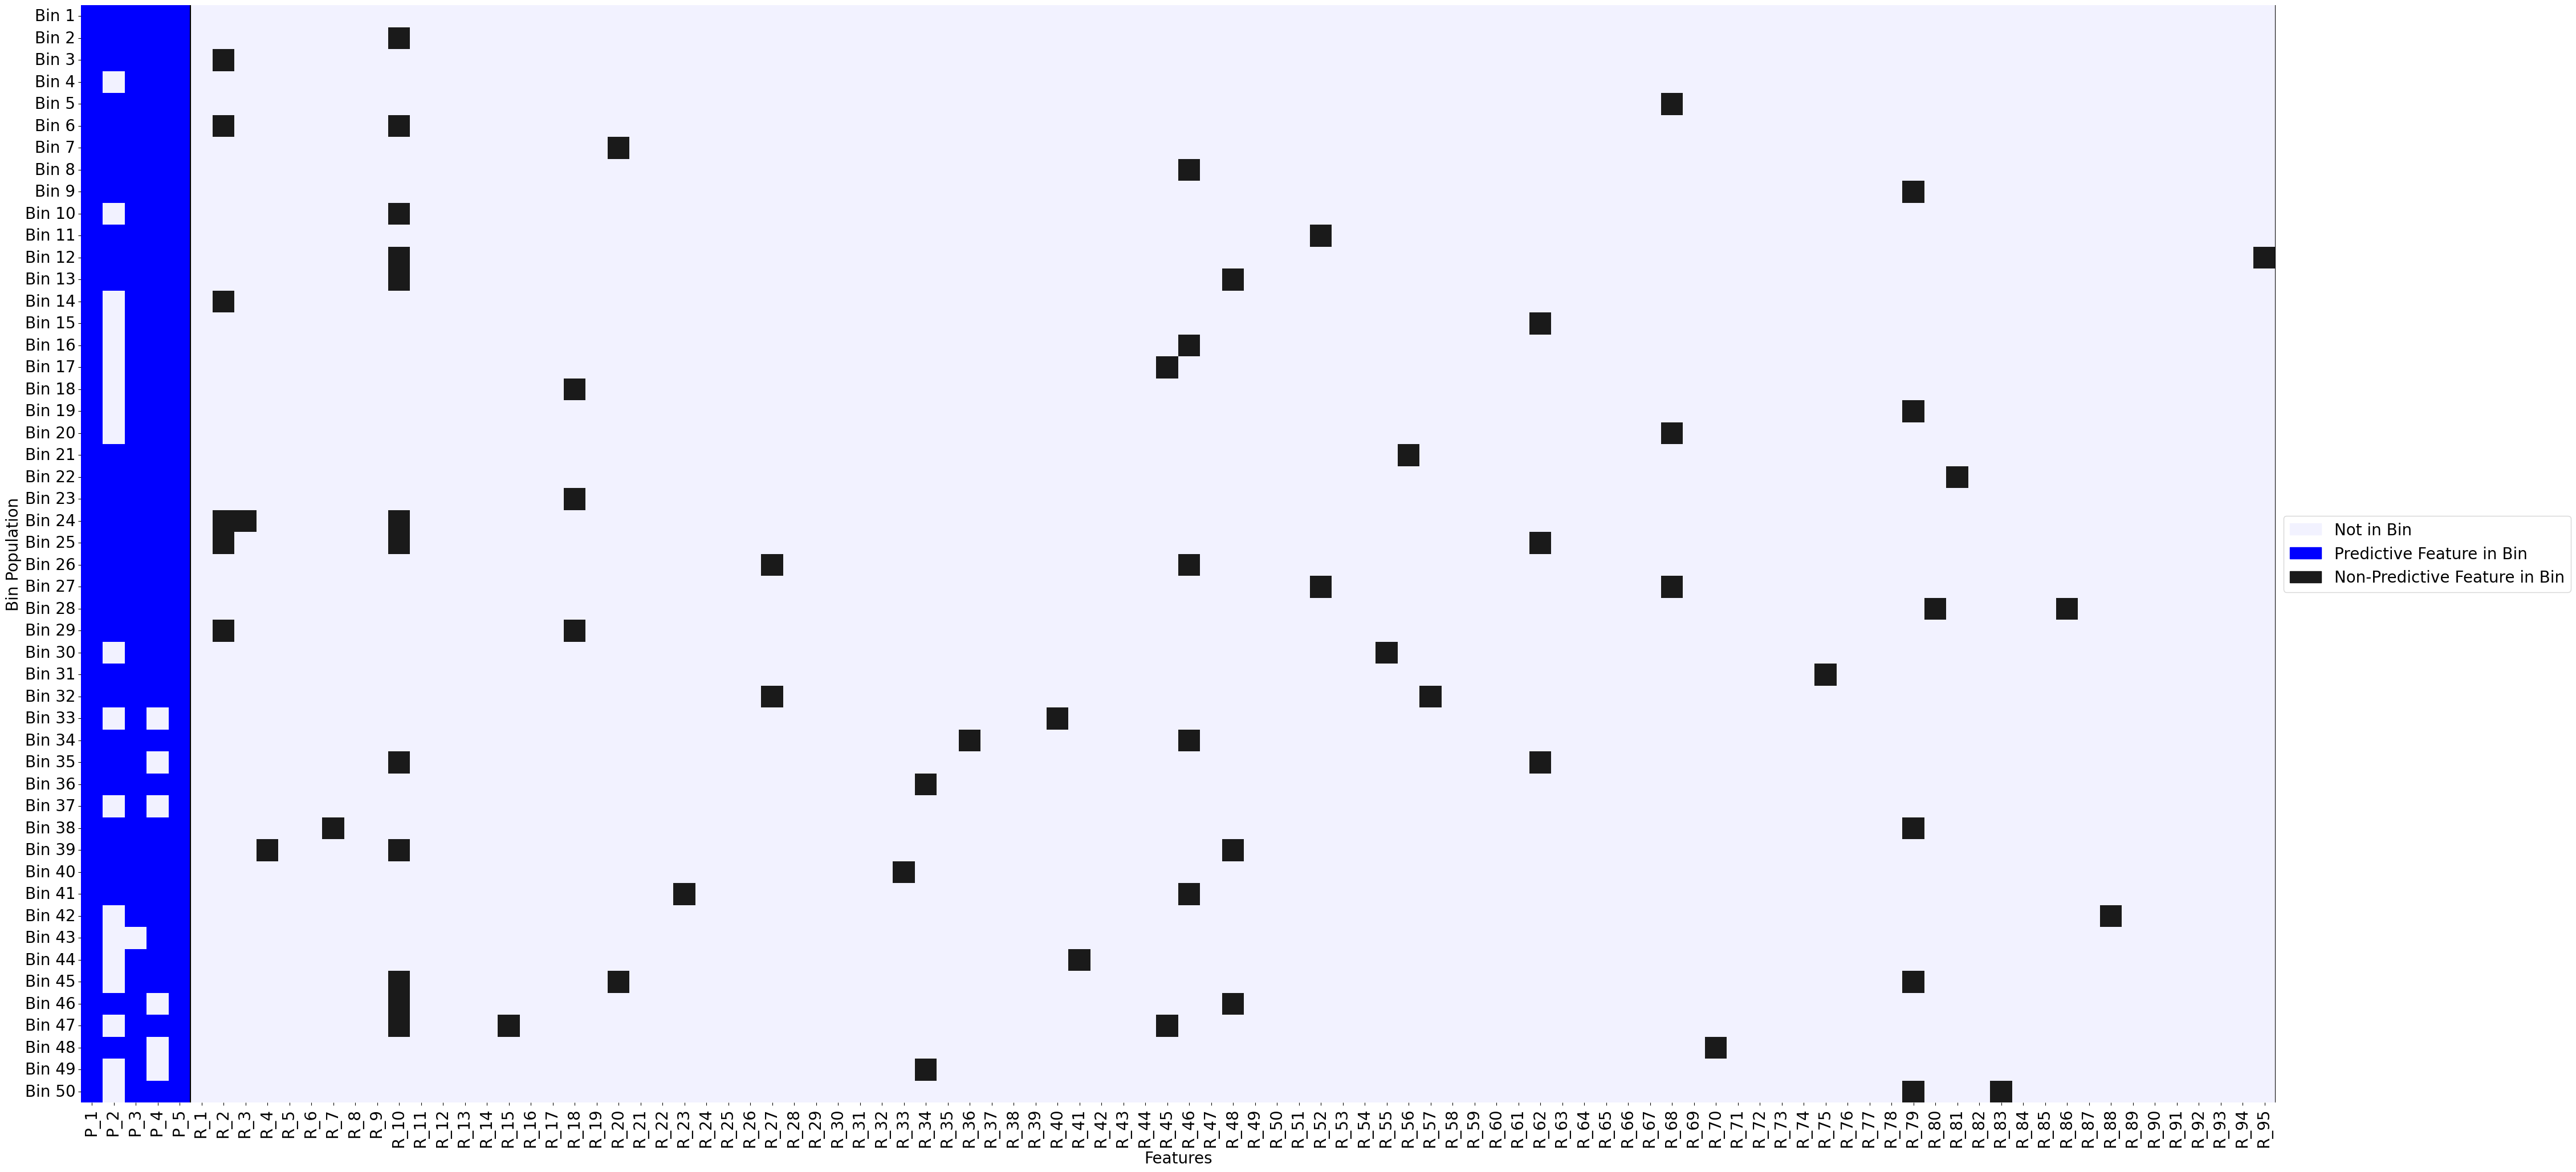

In [11]:
group_names=["P", "R"]
legend_group_info = ['Not in Bin','Predictive Feature in Bin','Non-Predictive Feature in Bin'] #2 default colors first followed by additional color descriptions in legend
colors = [(.95, .95, 1),(0, 0, 1),(0.1, 0.1, 0.1)] #very light blue, blue, ---Alternatively red (1, 0, 0)  orange (1, 0.5, 0)
max_bins = 100
max_features = 100

fibers.get_custom_bin_population_heatmap_plot(group_names,legend_group_info,colors,max_bins,max_features,save=True,output_folder=output_folder,data_name=data_name)

### Plot: Bin Population Pareto Front
In plot, dot colors indicate the 'group strata prop' of the given bin, and dot size is relative to the 'group threshold of that bin'.

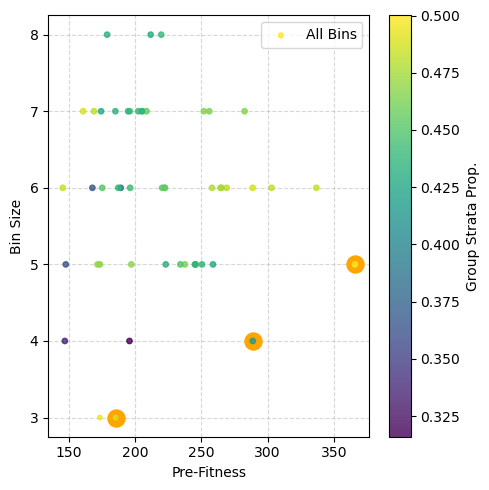

In [12]:
fibers.get_pareto_plot(save=True,output_folder=output_folder,data_name=data_name)

### Plot: Estimated Feature Tracking Scores
These scores accumulate throughout the training process, and do not nesessarily reflect feature importance of individual bins or the final bin population.

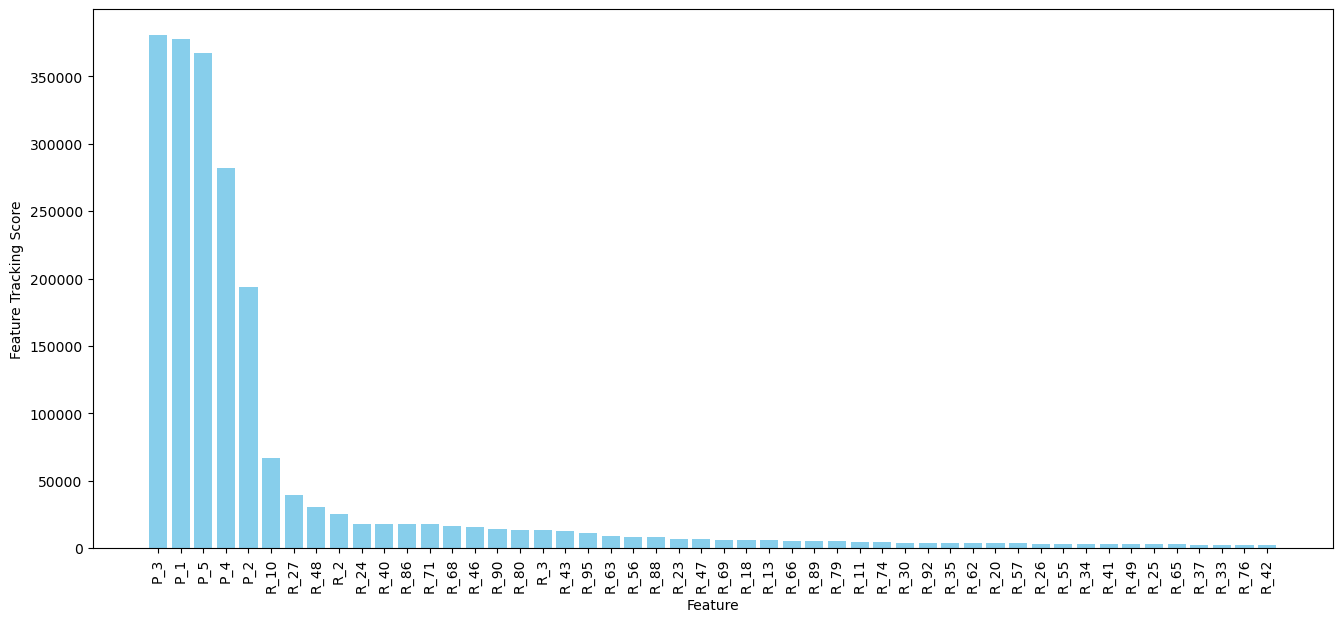

In [13]:
fibers.get_feature_tracking_plot(max_features=50,save=True,output_folder=output_folder,data_name=data_name)

### Plot: Dataset Covariate Residuals (if applicable)

In [14]:
if fibers.fitness_metric == 'residuals' or fibers.fitness_metric == 'log_rank_residuals':  
    fibers.get_residuals_histogram(save=True,output_folder=output_folder,data_name=data_name)

### Plot: Bin Log-Rank Scores Vs. Residuals Scores (if applicable)
In plot, dot colors indicate the 'group strata prop' of the given bin, and dot size is relative to the 'group threshold of that bin'.

In [15]:
if fibers.fitness_metric == 'log_rank_residuals':
    fibers.get_log_rank_residuals_plot(save=True,output_folder=output_folder,data_name=data_name)

###  Evaluate All Bins in Population using Cox PH Model (Can be slow)

In [16]:
if not quick_run:
    fibers.calculate_cox_prop_hazards(data)

### Plot: Bin Log-Rank Scores Vs. Adjusted Hazard Ratios (if applicable)
In plot, dot colors indicate the 'group strata prop' of the given bin, and dot size is relative to the 'group threshold of that bin'.

In [17]:
if not quick_run:
    if fibers.fitness_metric == 'log_rank' or fibers.fitness_metric == 'log_rank_residuals':  
        fibers.get_log_rank_adj_HR_plot(save=True,output_folder=output_folder,data_name=data_name)

### Plot: Bin Adjusted Hazard Ratios Vs. Residuals Scores (if applicable)
In plot, dot colors indicate the 'group strata prop' of the given bin, and dot size is relative to the 'group threshold of that bin'.

In [18]:
if not quick_run:
    if fibers.fitness_metric == 'residuals' or fibers.fitness_metric == 'log_rank_residuals':   
        fibers.get_adj_HR_residuals_plot(save=True,output_folder=output_folder,data_name=data_name)

### Plot: Bin Adjusted Hazard Ratios Vs. Log Rank * Residuals Scores (if applicable)
In plot, dot colors indicate the 'group strata prop' of the given bin, and dot size is relative to the 'group threshold of that bin'.

In [19]:
if not quick_run:
    if fibers.fitness_metric == 'log_rank_residuals':   
        fibers.get_adj_HR_metric_product_plot(save=True,output_folder=output_folder,data_name=data_name)

***
## History of Bin Evolution (Top Bin Each Generation)
### Plot: Pre-Fitness of top bin across training iterations

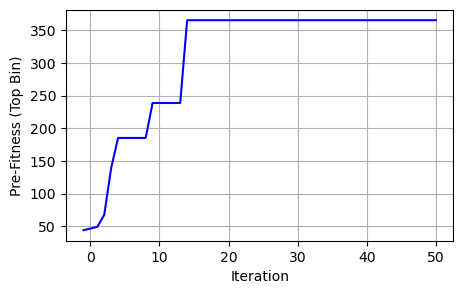

In [20]:
fibers.get_perform_progress_plot(save=True,output_folder=output_folder,data_name=data_name)

### Plot: Threshold of top bin across training iterations

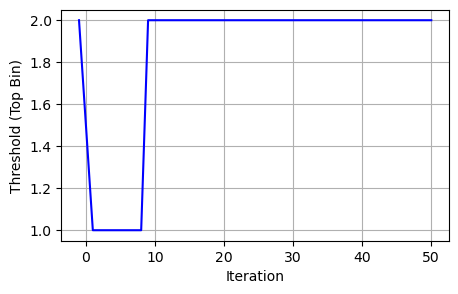

In [21]:
fibers.get_threshold_progress_plot(save=True,output_folder=output_folder,data_name=data_name)

### Plot: Normalized Top-Bin Stats Across Training Iterations

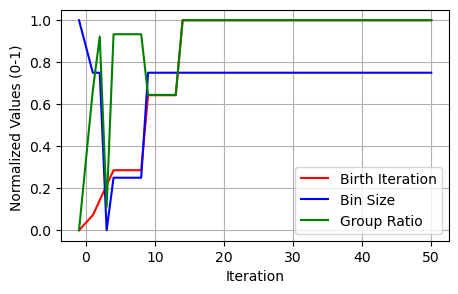

In [22]:
fibers.get_misc_progress_plot(save=True,output_folder=output_folder,data_name=data_name)

### View Top Bin Information Across all Iterations/Generations

In [23]:
fibers.perform_track_df
fibers.perform_track_df.to_csv(output_folder+'/'+data_name+'_tracking.csv', index=False)

***
## Save Bin Population
### Save Bin Population Details to CSV

In [24]:
pop_df = fibers.get_pop()
pop_df.to_csv(output_folder+'/'+data_name+'_pop.csv', index=False)

### Pickle Trained FIBERS Object (For Future Use)

In [25]:
with open(output_folder+'/'+data_name+'.pickle', 'wb') as f:
    pickle.dump(fibers, f)

***
## Transforming Bins Into New Features (i.e. Feature Learning) and Save as New CSV Files
### Transform Bins Using Total Sums (i.e. Respective Bin Thresholds Not Applied)

In [26]:
tdf = fibers.transform(data,full_sums=True)
tdf.to_csv(output_folder+'/'+data_name+'_transformed_full_sums.csv', index=False)
tdf

Dropped 0 invariant feature columns.


,Bin_0,Bin_1,Bin_2,Bin_3,Bin_4,Bin_5,Bin_6,Bin_7,Bin_8,Bin_9,...,Bin_42,Bin_43,Bin_44,Bin_45,Bin_46,Bin_47,Bin_48,Bin_49,Duration,Censoring
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.266046,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.374952,1
2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.563908,1
3,3.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,2.0,3.0,2.0,2.0,3.0,1.241518,0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.197085,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,2.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,1.047659,1
496,3.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,4.0,3.0,...,2.0,3.0,4.0,3.0,3.0,3.0,3.0,4.0,0.674139,1
497,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,...,2.0,4.0,4.0,4.0,4.0,3.0,3.0,5.0,1.094479,1
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.548070,0


### Transform Bins Using Respective Bin Threshold (i.e. 0 = At/Under Threshold Group and 1 = Over Threshold Group)

In [27]:
tdf = fibers.transform(data,full_sums=False)
tdf.to_csv(output_folder+'/'+data_name+'_transformed_threshold.csv', index=False)
tdf

Dropped 0 invariant feature columns.


,Bin_0,Bin_1,Bin_2,Bin_3,Bin_4,Bin_5,Bin_6,Bin_7,Bin_8,Bin_9,...,Bin_42,Bin_43,Bin_44,Bin_45,Bin_46,Bin_47,Bin_48,Bin_49,Duration,Censoring
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.266046,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.374952,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.563908,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,0,0,1,1.241518,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.197085,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.047659,1
496,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0.674139,1
497,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.094479,1
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.548070,0


***
## Prediction (of Group/Strata)
### Predict Strata (Low vs. High) Using Top Bin

In [28]:
predictions = fibers.predict(data,bin_number=0)
print(classification_report(predictions, true_risk_group, digits=8))


              precision    recall  f1-score   support

           0  1.00000000 1.00000000 1.00000000       250
           1  1.00000000 1.00000000 1.00000000       250

    accuracy                      1.00000000       500
   macro avg  1.00000000 1.00000000 1.00000000       500
weighted avg  1.00000000 1.00000000 1.00000000       500



### Predict Strata (Low vs. High) Using Whole Bin Population (Weighted Voting Scheme)
Assuming that a single bin can best solve the target survival problem (as is the case in this simulation), we expect prediction by all bins with this weighted voting scheme to perform less well.

In [29]:
predictions = fibers.predict(data)
print(classification_report(predictions, true_risk_group, digits=8))

              precision    recall  f1-score   support

           0  1.00000000 1.00000000 1.00000000       250
           1  1.00000000 1.00000000 1.00000000       250

    accuracy                      1.00000000       500
   macro avg  1.00000000 1.00000000 1.00000000       500
weighted avg  1.00000000 1.00000000 1.00000000       500



***
## Open Pickled FIBERS Object (Example)

In [30]:
with open(output_folder+'/'+data_name+'.pickle', 'rb') as f:
    fibers = pickle.load(f)

fibers.get_bin_report(bin_index)

,0
Features in Bin:,"[P_1, P_2, P_3, P_4, P_5]"
Threshold:,2
Fitness,1.0
Pre-Fitness:,365.620641
Log-Rank Score:,365.620641
Log-Rank p-value:,0.0
Bin Size:,5
Group Ratio:,0.5
Count At/Below Threshold:,250
Count Above Threshold:,250
